In [11]:
#utils 
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
def  symbol_to_path(symbol,base_dir='/home/machine_learning/anaconda3/ml4trading/data/'):
    """returns  CSV  file path given symbol"""
    return os.path.join(base_dir,"{}.csv".format(str(symbol)))
def get_data(symbols, dates, SPY500=True):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if SPY500 and 'SPY' not in symbols:   
        symbols = ['SPY'] + symbols

    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        df = df.join(df_temp)
        if symbol == 'SPY':   
            df = df.dropna(subset=["SPY"])

    return df
def normalize_data(df):
    """Normalize stock prices using the first row of the dataframe."""
    return df / df.ix[0]
def plot_data(df,title="Stock prices"):
    import  matplotlib
    from  matplotlib import pyplot as plt
    """ plot  stock prices"""
    %matplotlib inline
    ax=df.plot(title=title, fontsize=2)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()
def plot_selected(df, columns,  start_index,end_index):
    subseted=df.ix[pd.date_range(start_index,end_index),columns].dropna()
    plot_data(subseted)
        

In [12]:
def compute_daily_returns(df):
    #(price[t]/price[t-1])-1    to  give percent
    daily_returns=df.copy()
    daily_returns[1:]=(df[1:]/df.values[:-1])-1
    daily_returns.ix[0,:]=0
    return  daily_returns[1:]
    

In [13]:
def  get_statistics(historical_prices,alloc,risk_free_rate,period,total_invest):
    #1  normalize prices  :
    historical_prices=normalize_data(historical_prices)
    #2 for  each  row in  historical normalized data   multiplies  with allocations  to  apply percentage of investment
    allocated_history=historical_prices*alloc
    #3  ending   values  of  those allocations
    end_val=allocated_history.sum(axis=1)*total_invest
    #4 cummulative return : (s[t]/s[0])-1
    #end_val=list(end_val)#because  simming on row    brings   series
    cumul=end_val[-1]/end_val[0]-1
    #5 daily returns - must  convert back to    df
    end_val=pd.DataFrame(end_val)
    daily_return=compute_daily_returns(end_val)
    #6  and 7  average daily return 
    average_daily_return=daily_return.mean()
    std_daily_return=daily_return.std()
    #8  sharpe  ratio    average  of returns - risk  rate  divided  by   std of   returns  *  sqrt period
    sharpe_ratio=period/np.sqrt(period) *(average_daily_return/std_daily_return)
    #9 compute ending value of portofolio 
    # to do
    return  cumul,average_daily_return,std_daily_return,sharpe_ratio,end_val
    
    

In [14]:
def  asses_portofolio(dates,symbols,alloc,risk,total,period,plot):
    # retrieve data
    import  matplotlib 
    from matplotlib  import  pyplot  as plt
    %matplotlib inline
    df=get_data(symbols,dates)
    #retain SPY  prices   before drop in order  not to  query again 
    spy=df['SPY']
    df=df.drop('SPY',axis=1)
    cumul,avg_daily,stdD,sharpe_ratio,end_val=get_statistics(df,alloc,risk,df.shape[0],total)
    print('Cumulative  value of portofolio is  ' ,cumul)
    print('Average_daily ',(avg_daily))
    print('Std_daily',stdD)
    print('Sharpe ratio',sharpe_ratio)
 
    #spy=spy*total
    spy=normalize_data(spy)*total
    end_val.columns=['Our Portofolio']
    if plot==True:
        compare=pd.concat([end_val,spy],axis=1)
        compare.plot(title="Our daily portofolio")
    return  sharpe_ratio
    

    
    

initial alloc [0.25, 0.25, 0.25, 0.25]
Cumulative  value of portofolio is   0.248764673842
Average_daily  0    0.000402
dtype: float64
Std_daily 0    0.014705
dtype: float64
Sharpe ratio 0    0.751605
dtype: float64


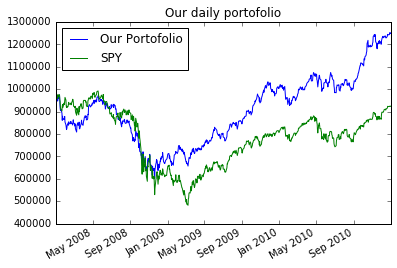

In [24]:
######3test for   2008-2010 interval
dates=pd.date_range('2008-01-01', '2010-12-31')
symbols=['GOOG', 'AAPL', 'GLD', 'XOM']
plot=False
risk=0.0
total=1000000
alloc=[1/len(symbols) for  stock  in range(len(symbols))]
print('initial alloc',alloc)
e=asses_portofolio(dates,symbols,alloc,risk,total,252.0,plot=True)

In [26]:
##################optimize  this period
dates=pd.date_range('2008-01-01', '2010-12-31')
symbols=['GOOG', 'AAPL', 'GLD', 'XOM']
plot=False
risk=0.0
total=1000000
alloc=[1/len(symbols) for  stock  in range(len(symbols))]
#e=asses_portofolio(dates,symbols,alloc,risk,total,252.0,plot)
def optimize_portofolio(dates,symbols,alloc,risk,total,period,plot=False):
    def loss_function(alloc):
        e=asses_portofolio(dates,symbols,alloc,risk,total,252.0,plot)
        return -e
    from scipy.optimize import minimize
    bounds=tuple((0,1) for stocks in range(len(alloc)))
    cons = ({'type':'eq', 'fun': lambda alloc: 1.0 - np.sum(inputs)})
    result=minimize(loss_function,alloc,method='SLSQP', bounds=bounds)
    return result
    
  
res=optimize_portofolio(dates,symbols,alloc,risk,total,252.0,plot)    
        
        
    

Cumulative  value of portofolio is   0.248764673842
Average_daily  0    0.000402
dtype: float64
Std_daily 0    0.014705
dtype: float64
Sharpe ratio 0    0.751605
dtype: float64
Cumulative  value of portofolio is   0.248764673842
Average_daily  0    0.000402
dtype: float64
Std_daily 0    0.014705
dtype: float64
Sharpe ratio 0    0.751605
dtype: float64
Cumulative  value of portofolio is   0.248764668151
Average_daily  0    0.000402
dtype: float64
Std_daily 0    0.014705
dtype: float64
Sharpe ratio 0    0.751605
dtype: float64
Cumulative  value of portofolio is   0.248764679902
Average_daily  0    0.000402
dtype: float64
Std_daily 0    0.014705
dtype: float64
Sharpe ratio 0    0.751605
dtype: float64
Cumulative  value of portofolio is   0.248764679593
Average_daily  0    0.000402
dtype: float64
Std_daily 0    0.014705
dtype: float64
Sharpe ratio 0    0.751605
dtype: float64
Cumulative  value of portofolio is   0.248764667721
Average_daily  0    0.000402
dtype: float64
Std_daily 0    0.01

In [27]:
res.x # the allocations

array([  0.00000000e+00,   5.35713114e-01,   9.60206077e-01,
         1.10410231e-16])

initial alloc [  0.00000000e+00   5.35713114e-01   9.60206077e-01   1.10410231e-16]
Cumulative  value of portofolio is   0.642137401829
Average_daily  0    0.000739
dtype: float64
Std_daily 0    0.012868
dtype: float64
Sharpe ratio 0    1.580183
dtype: float64


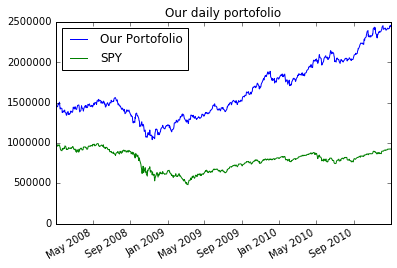

In [28]:
######see  if  improved   training history
dates=pd.date_range('2008-01-01', '2010-12-31')
symbols=['GOOG', 'AAPL', 'GLD', 'XOM']
plot=False
risk=0.0
total=1000000
alloc=res.x
print('initial alloc',alloc)
e=asses_portofolio(dates,symbols,alloc,risk,total,252.0,plot=True)

In [29]:
################################## test   2 years  furuture #########################################

initial alloc [0.25, 0.25, 0.25, 0.25]
Cumulative  value of portofolio is   0.413502635396
Average_daily  0    0.000863
dtype: float64
Std_daily 0    0.010197
dtype: float64
Sharpe ratio 0    1.750109
dtype: float64


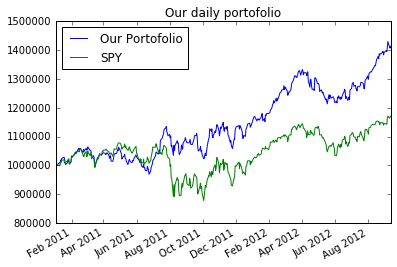

In [30]:
######see  if  improved   training history equal  allocation
dates=pd.date_range('2011-01-01', '2012-12-31')
symbols=['GOOG', 'AAPL', 'GLD', 'XOM']
plot=False
risk=0.0
total=1000000
alloc=[1/len(symbols) for  stock  in range(len(symbols))]
print('initial alloc',alloc)
e=asses_portofolio(dates,symbols,alloc,risk,total,252.0,plot=True)

initial alloc [  0.00000000e+00   5.35713114e-01   9.60206077e-01   1.10410231e-16]
Cumulative  value of portofolio is   0.511983783628
Average_daily  0    0.001019
dtype: float64
Std_daily 0    0.010085
dtype: float64
Sharpe ratio 0    2.091115
dtype: float64


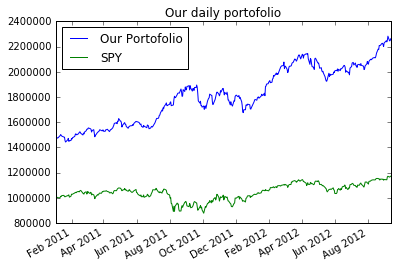

In [31]:
###########with learner     weights    2 years  in   the future 
######see  if  improved   training history equal  allocation
dates=pd.date_range('2011-01-01', '2012-12-31')
symbols=['GOOG', 'AAPL', 'GLD', 'XOM']
plot=False
risk=0.0
total=1000000
alloc=res.x
print('initial alloc',alloc)
e=asses_portofolio(dates,symbols,alloc,risk,total,252.0,plot=True)